## Brownlee adapted for live update

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

### Yet to do

1. Record the predicted data and create live streaming chart
2. Duplication in the live streaming input 
3. Add Twitter live sentiment analysis
4. Add additional features like volume, bidask, etc

In [114]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
import seaborn as sns

# import tensorflowvisu
import math
import numpy as np
import glob
from sklearn import preprocessing
# Set charts to view inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from math import sqrt

from numpy import concatenate
import sys
import requests
import datetime
import time

In [81]:
# plot size
plt.rcParams["figure.figsize"] = (15,10)

***

## Part 1 -- Data preparation
We load the price, volume, transaction, trades per minute, bidask, epu_idx and semantic (tweet) score from the spreadsheet we combined them into.

In [82]:
global df

In [83]:
# DATA698  Crypto Project
# market_data.py
#This file pulls the historical market data from cryptocompare.com


def arg_check():
    if len(arg) != 3:
        print ("Usage: Crypto BaseCurrency candle_size")
        
#https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=1828
        
def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df


def writecsv(df, filename):
    df[['timestamp','close']].to_csv(filename,index=False)
    print(filename, "saved")


def main():
    minute = minute_price_historical('BTC', 'USD', 2000, 1)
    writecsv(minute, './data/BTC_minute.csv')
    
if  __name__ =='__main__':
    main()

./data/BTC_minute.csv saved


In [84]:
df = pd.read_csv("./data/BTC_minute.csv")#,usecols=['timestamp','close'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()

# Taking the historical price alone
series = Series(df.drop('timestamp',axis=1)['close'])

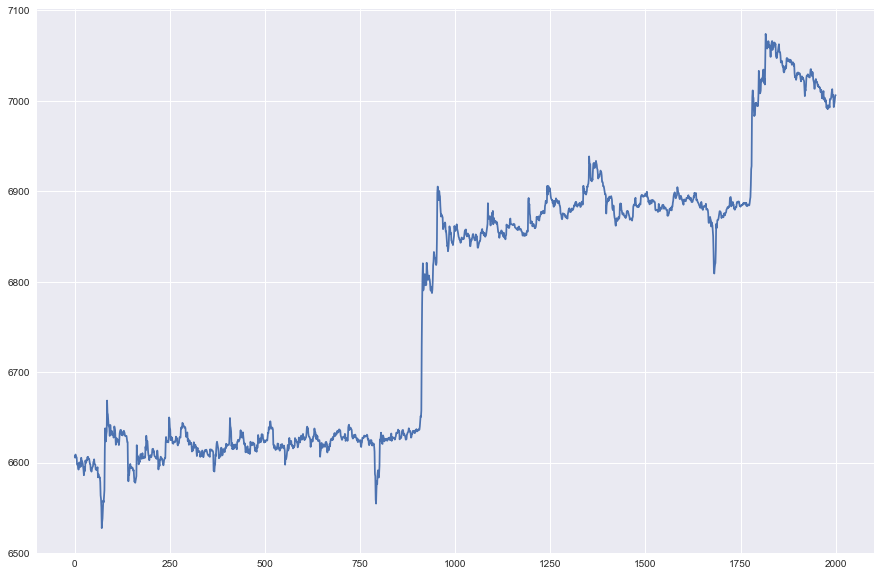

In [85]:
# get the data
#fname='data/btc_new_3_24.csv'
#df = pd.read_csv(fname)
df['close'].plot()
plt.show()

In [86]:
# we must drop any NaN rows for LSTM to run
df.dropna(inplace=True)

### Brownlee functions
These are some of the functions Brownlee wrote to transform and un-transform the data. We'll be using adapted versions for our model. We won't use all of them. Unlike prior runs, we will use his differencing function to make the data stationary before scaling it later in the process.

In [87]:
# date-time parsing function for loading the dataset; NOT USED
def parser(x):
	return datetime.strptime(x, '%Y-%b')

# frame a sequence as a supervised learning problem; NOT USED
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
# this base model is the one that worked best for me
# it uses hidden layers of 100, 20, 10 and 5 neurons

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model





# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# this function runs the lstm model for the repeat experiment function below
# I've commented out the data prep part, since we've done that already
# run a repeated experiment
def experiment(n_repeats, batch_size=1, n_epochs=1, n_neurons=1):
	# transform data to be stationary
	# raw_values = series.values
	# diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	# supervised = timeseries_to_supervised(diff_values, features)
	# supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	# train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	# scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, batch_size, n_epochs, n_neurons)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-600:], predictions))
		print('')
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		print('')
		error_scores.append(rmse)
	return error_scores


# this function can be used to configure and run multiple trials of a model
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# to run it
# run()


In [88]:
#def fit_lstm(train, batch_size, nb_epoch, neurons):
#    X, y = train[:, 0:-1], train[:, -1]
#    X = X.reshape(X.shape[0], 1, X.shape[1])
#    model = Sequential()
#    model.add(Bidirectional(LSTM(neurons, return_sequences=True), batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
#    model.add(LSTM(20, return_sequences=True))
#    model.add(LSTM(10, return_sequences=True))
#    model.add(LSTM(5))
#    model.add(Dense(1))
#    model.compile(loss='mean_squared_error', optimizer='adam')
#    for i in range(nb_epoch):
#        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
#        model.reset_states()
#    return model


In [89]:
#fit_lstm(train_scaled, 1, 10, 100)

In [90]:
## Not used for live update
#df.head()

### Difference the data
#Several variables are not stationary. For LSTM to work, the have to be differenced. We do that for transactions, bid-ask spread, volume and trades per minute. We will difference price in the next step so it synchronizes with the Brownlee functions.

#df_temp = df[['trans', 'bidask', 'volume', 'tpm']].diff(1,0)

#df_temp.info()

### Put it back together

# concatenate the data, rename columns
#new_df = pd.DataFrame(pd.concat([df_temp, df[['price','epu_idx', 'exp_sem']]], axis=1))

#new_df.head()

### Create the 1-day lagged price as target variable 'y'
We are trying to predict the next day's price based on the data we know today. The next series of steps adds our features together with y = t+1. So now we have the next day's true price (y) and today's knowledge (X) in each observation.

#### Step 1: Difference the price

In [91]:
# first we have to difference the price
# we're using Brownlee's function to do this so we can undifference it later
raw_values = df['close'].values
diff_values = difference(raw_values, 1)
diff_values.head()

0   -1.53
1    3.54
2   -2.29
3   -0.52
4   -0.33
dtype: float64

In [92]:
len(diff_values)
# check it
df['close'].diff(1).head()

0     NaN
1   -1.53
2    3.54
3   -2.29
4   -0.52
Name: close, dtype: float64

#### Step 2: Create our lagged ahead target price 'y'

In [93]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)

supervised.head()

,0,0
0,NaN,-1.53
1,-1.53,3.54
2,3.54,-2.29
3,-2.29,-0.52
4,-0.52,-0.33


#### Step 3: Combine with our other features

#### Step 4: Inspect

### Convert to an array
This is required by LSTM.

### Make training, test sets; scale the data
We have 1,824 observations. We'll train on 1,224 and test on 600. We use Brownlee's scale() function to rescale everything between (-1,1). This is required for LSTM.

In [94]:
# split data into train and test-sets
train, test = supervised_values[0:-600, :], supervised_values[-600:, :]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# make X, y training set; this is done in the next function
# X, y = train_scaled[:, 0:-1], train_scaled[:, -1]

train_scaled

len(train), len(test)

train_scaled.shape

(1224, 2)

***

## Part 2 -- Modeling

### Modified Brownlee for multiple experiments
This code will run repeat models and average them. It takes repeats, number of epochs and number of neurons in first layer and feeds those parameters to the lstm function above.

Epoch 1/1
 - 11s - loss: 0.0129
Epoch 1/1
 - 6s - loss: 0.0114
Epoch 1/1
 - 6s - loss: 0.0113
Epoch 1/1
 - 6s - loss: 0.0113
Epoch 1/1
 - 6s - loss: 0.0112
Epoch 1/1
 - 6s - loss: 0.0112
Epoch 1/1
 - 6s - loss: 0.0112
Epoch 1/1
 - 6s - loss: 0.0111
Epoch 1/1
 - 6s - loss: 0.0111
Epoch 1/1
 - 6s - loss: 0.0111

1) Test RMSE: 17.754

Epoch 1/1
 - 11s - loss: 0.0128
Epoch 1/1
 - 6s - loss: 0.0114
Epoch 1/1
 - 6s - loss: 0.0113
Epoch 1/1
 - 6s - loss: 0.0113
Epoch 1/1
 - 6s - loss: 0.0112
Epoch 1/1
 - 6s - loss: 0.0112
Epoch 1/1
 - 6s - loss: 0.0112
Epoch 1/1
 - 6s - loss: 0.0111
Epoch 1/1
 - 6s - loss: 0.0111
Epoch 1/1
 - 6s - loss: 0.0111

2) Test RMSE: 17.460

         results
count   2.000000
mean   17.607242
std     0.207589
min    17.460454
25%    17.533848
50%    17.607242
75%    17.680636
max    17.754030


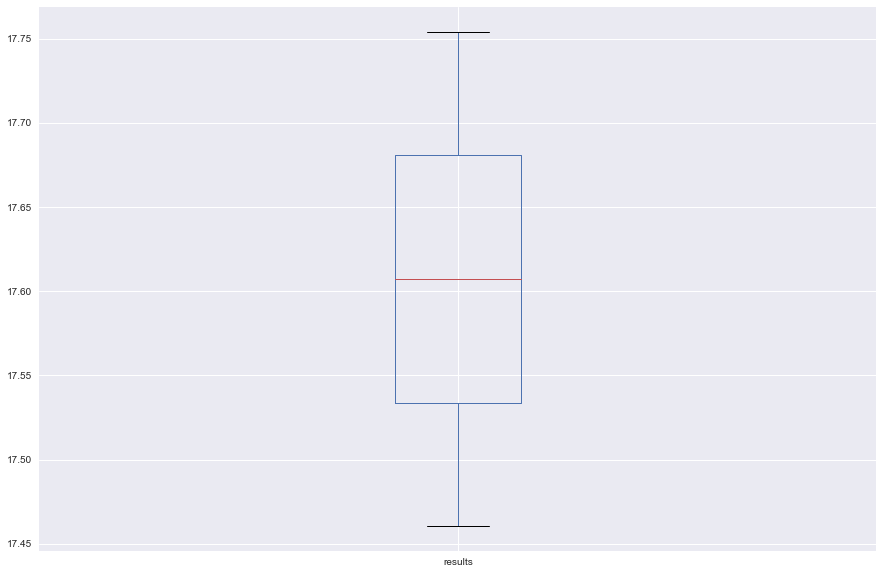

In [95]:
# configure a repeated experiment
# batch size should remain at 1; repeats, epochs and neurons can change
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# entry point
run()

### Single run model
This just runs a single model, and you can then plot the predicted vs. actual test values in the bottom cell.

In [98]:
# scale train and test data to [-1, 1]
def scale_one(supervised_df):
    supervised_df.dropna(inplace=True)
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(supervised_df)
    # transform train
    df_scaled = scaler.transform(supervised_df)
    return scaler, df_scaled

In [99]:
# split data into train test-sets
scalar, train_scaled = scale_one(supervised)


In [100]:
lstm_model = fit_lstm(train_scaled, 1, 10, 100)

Epoch 1/1
 - 14s - loss: 0.0146
Epoch 1/1
 - 10s - loss: 0.0113
Epoch 1/1
 - 10s - loss: 0.0113
Epoch 1/1
 - 10s - loss: 0.0112
Epoch 1/1
 - 10s - loss: 0.0111
Epoch 1/1
 - 10s - loss: 0.0111
Epoch 1/1
 - 9s - loss: 0.0111
Epoch 1/1
 - 10s - loss: 0.0110
Epoch 1/1
 - 11s - loss: 0.0110
Epoch 1/1
 - 10s - loss: 0.0110


In [101]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (1, 1, 100)               40800     
_________________________________________________________________
lstm_22 (LSTM)               (1, 1, 20)                9680      
_________________________________________________________________
lstm_23 (LSTM)               (1, 1, 10)                1240      
_________________________________________________________________
lstm_24 (LSTM)               (1, 5)                    320       
_________________________________________________________________
dense_6 (Dense)              (1, 1)                    6         
Total params: 52,046
Trainable params: 52,046
Non-trainable params: 0
_________________________________________________________________


#### Live Prediction

In [115]:
# scale train and test data to [-1, 1]
def transform_test(test_new_records):

    #print(test_new_records)
    # Concatinate original train and new test data to take a difference
    test_new_records = pd.concat([pd.DataFrame(df.iloc[-2:,:]),test_new_records])
    
    # Perform difference and timeseries on the new dataset
    test_diff_new_records = difference(test_new_records[['close']].values,1)
    #print(test_diff_new_records)
    ts_test_diff_new_records = timeseries_to_supervised(test_diff_new_records, 1)
    ts_test_diff_new_records.dropna(inplace=True)
    # Scale transform test dataset
    test_scaled = scalar.transform(ts_test_diff_new_records)
    
    return scalar, test_scaled

In [116]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
    
            
    # Perform difference and timeseries on the new dataset
    train_diff_new_records = difference(train,1)
    
    # Perform other regular updates
    #print(test_diff_new_records)
    ts_train_diff_new_records = timeseries_to_supervised(train_diff_new_records, 1)
    
    # Scale transform train dataset    
    scalar, train_scaled = scale_one(ts_train_diff_new_records)
    
    X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    for i in range(updates):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    
    
    return model

In [117]:
def minute_price_historical(lstm_model, symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
        .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    
    page = requests.get(url)
    data = page.json()['Data']
    test_df = pd.DataFrame(data)
    test_df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in test_df.time]
    test_df = test_df[['timestamp','close']]
    
    # New Price 
    print("\nActual price:")
    #print(test_df)
    
    # Append rows to parent dataframe
    global df
    df = pd.concat([df,test_df],axis=0,ignore_index=True)
    
    print(df.tail())
    
    # Add the live data to input file
    with open('data/BTC_minute.csv','a') as f:
        test_df[['timestamp','close']].to_csv(f,header=False,index=False)

    #print(test_df)
    scalar, test_scaled = transform_test(test_df)
    
    #print("\n Test Scaled:")
    #print(test_scaled)
    
    #Update LSTM model with new data
    lstm_model = update_model(lstm_model, df[['close']].values, 1, 1)
    
    # Predict the next price
    batch_size = 1
    yhat = forecast_lstm(lstm_model, batch_size, test_scaled[-1:,0])
    
    #Invert scale and difference
    yhat = invert_scale(scalar, test_scaled[-1:,0], yhat)

    yhat_inverse = test_df.iloc[-1,1] + yhat
    
    #Time delta for next prediction
    t = datetime.timedelta(minutes=1)
    
    print("\n Next Predicted Price time: ",test_df.iloc[-1,0]+t)
    print(yhat_inverse)
    
    print("\n Prediction:")
    print('BUY' if yhat_inverse >  df.iloc[-1,1] else 'SELL')
    
    time.sleep(40)
    
    return test_df.iloc[-1,0]+t, yhat_inverse
    

In [123]:
# For recording predicted data - Yet to complete
predicted_yhat =pd.DataFrame(columns=['timestamp','yhat'])
predicted_yhat 

,timestamp,yhat


In [124]:

while True:
    predicted_yhat.append({timestamp}minute_price_historical(lstm_model,'BTC', 'USD', 1, 1),ignore_index=True)
    


Actual price:
               timestamp    close
2022 2018-04-07 15:22:00  7005.87
2023 2018-04-07 15:22:00  7006.05
2024 2018-04-07 15:23:00  7002.62
2025 2018-04-07 16:28:00  7021.03
2026 2018-04-07 16:29:00  7025.96
Epoch 1/1
 - 11s - loss: 0.0109

 Next Predicted Price time:  2018-04-07 16:30:00
7025.8956955

 Prediction:
SELL

Actual price:
               timestamp    close
2024 2018-04-07 15:23:00  7002.62
2025 2018-04-07 16:28:00  7021.03
2026 2018-04-07 16:29:00  7025.96
2027 2018-04-07 16:29:00  7024.50
2028 2018-04-07 16:30:00  7024.70
Epoch 1/1
 - 11s - loss: 0.0108

 Next Predicted Price time:  2018-04-07 16:31:00
7024.83295486

 Prediction:
BUY

Actual price:
               timestamp    close
2026 2018-04-07 16:29:00  7025.96
2027 2018-04-07 16:29:00  7024.50
2028 2018-04-07 16:30:00  7024.70
2029 2018-04-07 16:30:00  7024.70
2030 2018-04-07 16:31:00  7024.62
Epoch 1/1
 - 10s - loss: 0.0108

 Next Predicted Price time:  2018-04-07 16:32:00
7024.81544455

 Prediction:
BUY


KeyboardInterrupt: 

In [131]:
df.head()

,timestamp,close
0,2018-04-06 05:48:00,6606.87
1,2018-04-06 05:49:00,6605.34
2,2018-04-06 05:50:00,6608.88
3,2018-04-06 05:51:00,6606.59
4,2018-04-06 05:52:00,6606.07


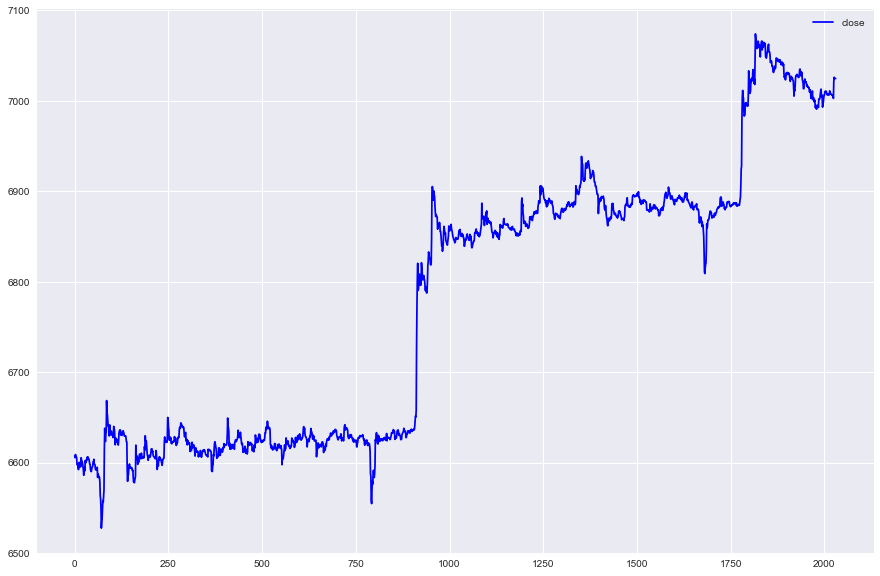

In [140]:
df[['close']].plot(color='blue')
plt.show()

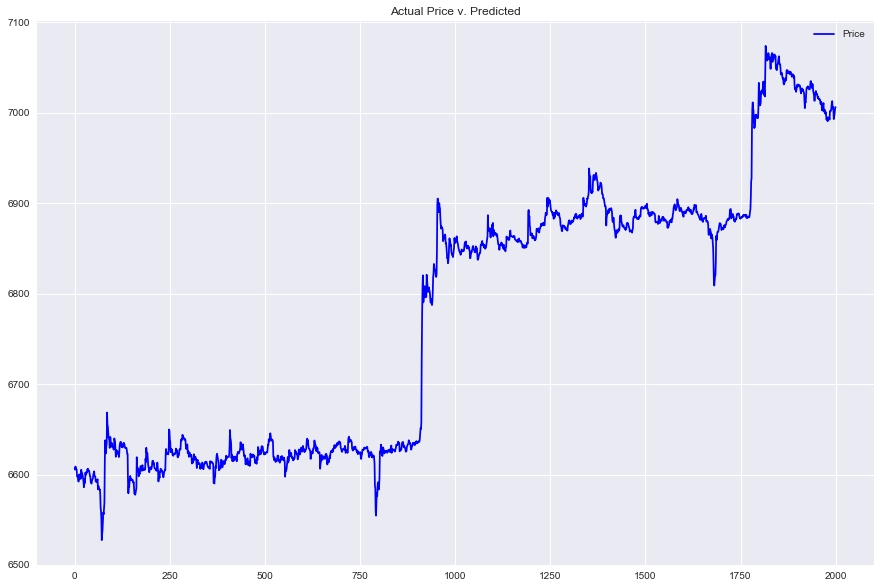

In [119]:
#Plot actual versus predicted:
#orig = plt.plot(raw_values, color='blue',label='Price')
#pred = plt.plot(predictions, color='red', label='Predicted')
#plt.legend(loc='best')
#plt.title('Actual Price v. Predicted')
#plt.show()

#pd.DataFrame(predictions).to_csv('predict_3_24.csv'); new_df.to_csv('new_df_3_24.csv')

#pd.DataFrame(raw_values[-600:]).to_csv('raw_values_3_24.csv')